In [19]:
import acl
import numpy as np
from PIL import Image, ImageDraw
from acl_sample import Sample
import struct
from constant import NPY_BYTE, ACL_MEMCPY_DEVICE_TO_HOST
from postprocessing import postprocess_boxes
import cv2

In [2]:
device_id = 0
input_size = 416
model_path = "./model/yolov3_caffe.om"
img_dict = {"path": "./data/dog.jpg", "dtype": np.uint8}

In [3]:
sample = Sample(device_id,
                model_path,
                input_size,
                input_size)

[Sample] init resource stage:
[Sample] init resource stage success
[Model] class Model init resource stage:
model output size 2
output  0
model output dims ({'name': 'detection_out3:0:box_out', 'dimCount': 2, 'dims': [1, 6144]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'detection_out3:1:box_out_num', 'dimCount': 2, 'dims': [1, 8]}, 0)
model output datatype 3
model input size 2
input  0
model input dims ({'name': 'data', 'dimCount': 4, 'dims': [1, 416, 416, 3]}, 0)
model input datatype 4
input  1
model input dims ({'name': 'img_info', 'dimCount': 2, 'dims': [1, 4]}, 0)
model input datatype 0
[Model] create model output dataset:
[Model] create model output dataset success
[Model] class Model init resource stage success


In [4]:
# %timeit -n 100 -r 10 
model_output = sample.forward(img_dict)

[Sample] width:768 height:576
[Sample] image:./data/dog.jpg
[Dvpp] vpc decode stage:
[Dvpp] vpc decode stage success
[Dvpp] vpc resize stage:
[Dvpp] vpc resize stage success
dvpp_output_buffer 17729627357184
dvpp_output_size 259584
[Model] create model input dataset:
[Model] create model input dataset success
[Model] execute stage:
[Model] execute stage success


In [5]:
acl.mdl.get_dataset_num_buffers(model_output)

2

In [24]:
def get_model_output_by_index(model_output, i, num_classes = 80):
    temp_output_buf = acl.mdl.get_dataset_buffer(model_output, i)

    infer_output_ptr = acl.get_data_buffer_addr(temp_output_buf)
    infer_output_size = acl.get_data_buffer_size(temp_output_buf)
#     print("infer_output_size", infer_output_size)
    
    output_host, _ = acl.rt.malloc_host(infer_output_size)
    acl.rt.memcpy(output_host, infer_output_size, infer_output_ptr,
                          infer_output_size, ACL_MEMCPY_DEVICE_TO_HOST)
    
    result = acl.util.ptr_to_numpy(output_host, (infer_output_size,), NPY_BYTE)
    return np.array(struct.unpack(f"{infer_output_size//4}f", bytearray(result)), dtype=np.float32)
# .reshape(-1, 255)

In [25]:
temp_output_buf = acl.mdl.get_dataset_buffer(model_output, 1)

infer_output_ptr = acl.get_data_buffer_addr(temp_output_buf)
infer_output_size = acl.get_data_buffer_size(temp_output_buf)
print("infer_output_size", infer_output_size)

output_host, _ = acl.rt.malloc_host(infer_output_size)
acl.rt.memcpy(output_host, infer_output_size, infer_output_ptr,
                      infer_output_size, ACL_MEMCPY_DEVICE_TO_HOST)

result = acl.util.ptr_to_numpy(output_host, (infer_output_size,), NPY_BYTE)
box_out_num = struct.unpack(f"{infer_output_size//4}I", bytearray(result))

infer_output_size 32


In [9]:
box_out = get_model_output_by_index(model_output, 0)

infer_output_size 24576


In [26]:
objNum = box_out_num[0]
boxes = []
for k in range(objNum):
    pos = 0
    leftTopX = box_out[objNum * (pos) + k]
    pos += 1
    leftTopY = box_out[objNum * (pos) + k]
    pos += 1
    rightBotX = box_out[objNum * (pos) + k]
    pos += 1
    rightBotY = box_out[objNum * (pos) + k]
    pos += 1
    confidence = box_out[objNum * (pos) + k]
    pos += 1
    classId = box_out[objNum * (pos) + k]
    pos += 1
    print(leftTopX, leftTopY, rightBotX, rightBotY, confidence, classId)
    boxes.append([leftTopX, leftTopY, rightBotX, rightBotY])

153.0 72.5625 571.0 477.5 0.99316406 1.0
470.25 20.8125 692.0 125.125 0.9638672 7.0
120.75 206.5 324.25 575.0 0.9970703 16.0


In [27]:
img = Image.open(img_dict["path"])

In [28]:
img1 = ImageDraw.Draw(img)
for box in boxes:
    img1.rectangle(box, outline ="red")

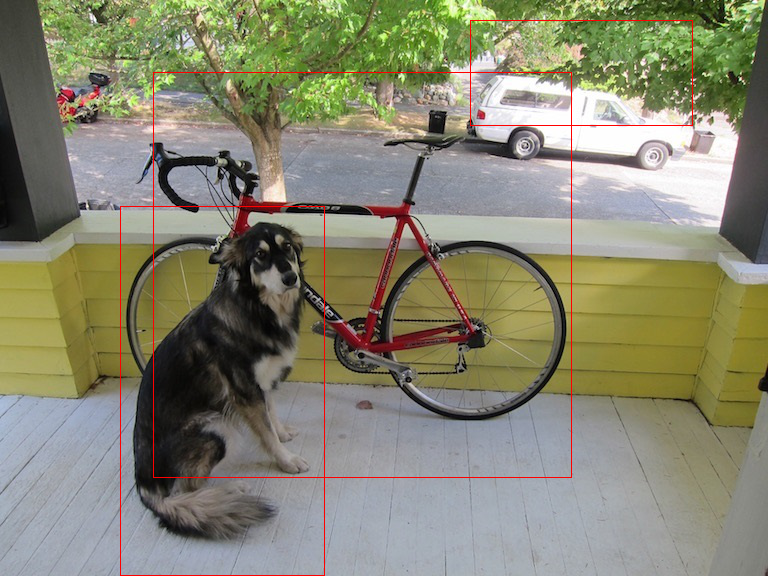

In [29]:
img